In [53]:
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.io
import ase.visualize
from rholearn.options import get_options
from rholearn.rholearn import train_utils as rho_train_utils
from rholearn.utils import io, system

## Initialization

In [57]:
dft_options = get_options("dft", "doslearn")
ml_options = get_options("ml", "doslearn")
if dft_options.get("IDX_SUBSET") is not None:
        frame_idxs = dft_options.get("IDX_SUBSET")
else:
    frame_idxs = None

all_frames = system.read_frames_from_xyz(dft_options["XYZ"], frame_idxs)\

if frame_idxs is None:
        frame_idxs = list(range(len(all_frames)))

_, _, test_id = (
        rho_train_utils.crossval_idx_split(  # cross-validation split of idxs
            frame_idxs=frame_idxs,
            n_train=ml_options["N_TRAIN"],
            n_val=ml_options["N_VAL"],
            n_test=ml_options["N_TEST"],
            seed=ml_options["SEED"],
        )
    )


In [ ]:
max_energy = dft_options["DOS_SPLINES"]["max_energy"] - ml_options["TARGET_DOS"]["max_energy_buffer"]
min_energy = dft_options["DOS_SPLINES"]["min_energy"]
interval = dft_options["DOS_SPLINES"]["interval"]

n_grid_points = int(np.ceil((max_energy - min_energy) \
                / interval))
x_dos = min_energy + np.arange(n_grid_points) * interval


## Test Statistics

Test Statistics
RMSE:  1.9208


Text(0, 0.5, 'MSE')

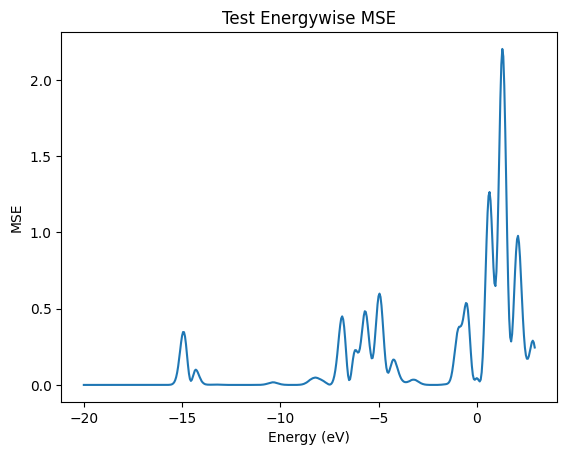

In [ ]:
test_mse = np.load('./evaluation/epoch_best/Test/test_MSEs.npy')
test_emse = np.load('./evaluation/epoch_best/Test/test_eMSEs.npy')

print ("Test Statistics")
print ("RMSE: ", f'{np.sqrt(np.mean(test_mse)):.5}')
plt.title("Test Energywise MSE")
plt.plot(x_dos, test_emse)
plt.xlabel("Energy (eV)")
plt.ylabel("MSE")

## Inspecting highest error prediction

Text(0, 0.5, 'DOS')

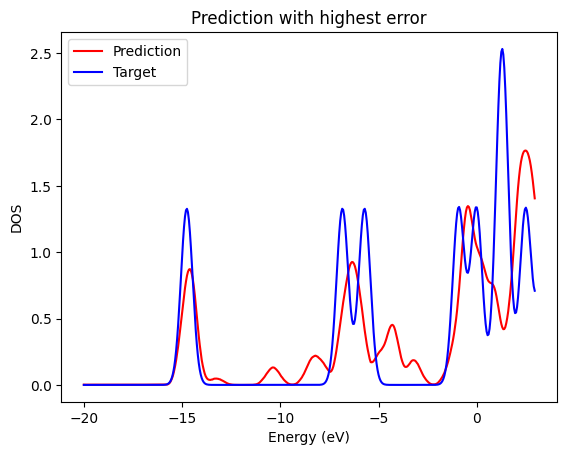

In [63]:
max_index = test_id[np.argmax(test_mse)]

# Load prediction and target

prediction = np.load(f'./evaluation/epoch_best/{max_index}/normalized_prediction.npy')
target = np.load(f'./evaluation/epoch_best/{max_index}/aligned_target.npy')

plt.plot(x_dos, prediction, color = 'red' , label = 'Prediction')
plt.plot(x_dos, target, color = 'blue', label = 'Target')
plt.legend()
plt.title("Prediction with highest error")
plt.xlabel("Energy (eV)")
plt.ylabel("DOS")